In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=r'C:\Users\777\PycharmProjects\uchuneyronki\NN\MNIST\CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root=r'C:\Users\777\PycharmProjects\uchuneyronki\NN\MNIST\CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


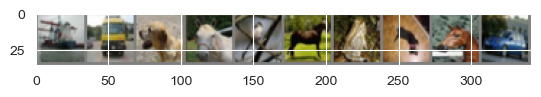

 ship truck   dog horse  bird horse  frog   cat horse   car


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images

imshow(torchvision.utils.make_grid(images, nrow=10))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))


In [20]:
for im, mark in train_dataloader:
    print(im.shape)
    break

torch.Size([64, 3, 32, 32])


Датасет представляет собой набор картинок из 10 классов размером 32х32х3. Всего 50000 картинок для тренировочной выборки и 10000 для тестовой.

In [5]:
total = 0
dic_count = {i: 0 for i in range(10)}
dic_graph = {}

In [6]:
print(len(trainset))
print((len(testset)))

50000
10000


In [7]:
for dat in trainset:
    tens, mark = dat
    dic_count[int(mark)] += 1
    total += 1
tg = 0
for k,v in dic_count.items():
    print(f'Процентоное соотношение класса {classes[tg]} от общего кол-ва цифр: {v*100/total}%')
    dic_graph[classes[tg]]=v
    tg += 1


Процентоное соотношение класса plane от общего кол-ва цифр: 10.0%
Процентоное соотношение класса car от общего кол-ва цифр: 10.0%
Процентоное соотношение класса bird от общего кол-ва цифр: 10.0%
Процентоное соотношение класса cat от общего кол-ва цифр: 10.0%
Процентоное соотношение класса deer от общего кол-ва цифр: 10.0%
Процентоное соотношение класса dog от общего кол-ва цифр: 10.0%
Процентоное соотношение класса frog от общего кол-ва цифр: 10.0%
Процентоное соотношение класса horse от общего кол-ва цифр: 10.0%
Процентоное соотношение класса ship от общего кол-ва цифр: 10.0%
Процентоное соотношение класса truck от общего кол-ва цифр: 10.0%


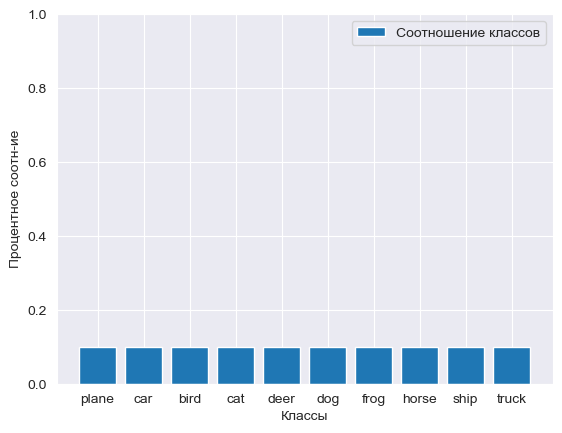

In [8]:
keys = dic_graph.keys()
vals = dic_graph.values()
plt.bar(keys, np.divide(list(vals), sum(vals)), label="Соотношение классов")
plt.ylim(0,1)
plt.ylabel("Процентное соотн-ие")
plt.xlabel("Классы")
plt.xticks(list(keys))
plt.legend()
plt.show()

Тренировочная выборка хорошо сбалансирована: по 5000 элементов для каждого класса

In [9]:
class Net_mlp(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super().__init__()
        self.activation = activation
        self.layers = nn.Sequential(
            nn.Linear(32*32*3, 1024),
            self.activation,
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            self.activation,
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            self.activation,
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [10]:
num_epochs = 20
batch_size = 64
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = Net_mlp().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Using cuda device


In [11]:
print(model)

Net_mlp(
  (activation): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [24]:
from torchsummary import summary
summary(model, (3072, 512))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (6144x512 and 3072x1024)

Архитектура сети имеет 3072 входа, то есть изображение 32х32 в 3ех каналах. В качестве функции активации была использована ReLu
![image](ReLUpic.jpg)
Затем идет слой из 1024, 512, 256, 128 и 10 выходных нейронов соответственно.

In [25]:
def train_loop(dataloader, model, loss_function, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        # предсказание и расчет потерь
        pred = model(imgs.to(device).view(-1,32*32*3))
        loss = loss_function(pred, labels.to(device))

        # оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Потери обучения: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device).view(-1,32*32*3))
            loss = loss_function(pred, labels.to(device))

            test_loss += loss.item()
            correct += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )

    test_loss /= num_batches
    correct /= size
    print(f"Потери на тестовых данных: {test_loss:>8f}, Точность модели на тестовых данных: {(100*correct):>0.1f}% \n")

    return test_loss

In [26]:
loss_history = {"train": [], "test": []}
start_time = time.time()
num_epochs = 10
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_dataloader, model, loss_function, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_function)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1
Потери обучения: 1.609046
Потери на тестовых данных: 1.451902, Точность модели на тестовых данных: 48.3% 

Эпоха номер 2
Потери обучения: 1.378023
Потери на тестовых данных: 1.372730, Точность модели на тестовых данных: 50.7% 

Эпоха номер 3
Потери обучения: 1.258457
Потери на тестовых данных: 1.319078, Точность модели на тестовых данных: 53.1% 

Эпоха номер 4
Потери обучения: 1.168538
Потери на тестовых данных: 1.312833, Точность модели на тестовых данных: 53.1% 

Эпоха номер 5
Потери обучения: 1.081824
Потери на тестовых данных: 1.283152, Точность модели на тестовых данных: 55.2% 

Эпоха номер 6
Потери обучения: 0.997796
Потери на тестовых данных: 1.290552, Точность модели на тестовых данных: 55.4% 

Эпоха номер 7
Потери обучения: 0.912591
Потери на тестовых данных: 1.309614, Точность модели на тестовых данных: 55.2% 

Эпоха номер 8
Потери обучения: 0.828611
Потери на тестовых данных: 1.345813, Точность модели на тестовых данных: 55.5% 

Эпоха номер 9
Потери обучения: 0

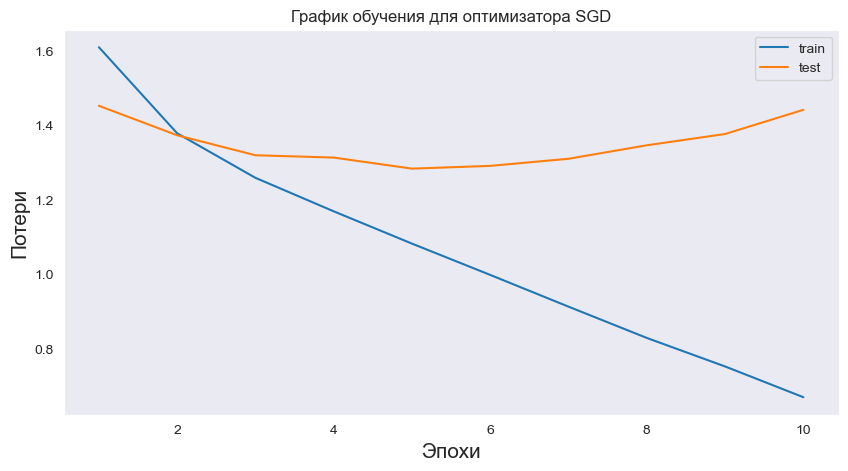

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.legend()
plt.grid()
plt.title("График обучения для оптимизатора SGD")
plt.show()

In [123]:
next(iter(test_dataloader))

TypeError: 'tuple_iterator' object is not callable

In [115]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images

imshow(torchvision.utils.make_grid(images, nrow=10))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

TypeError: 'tuple_iterator' object is not callable

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import f1_score

In [29]:
net = model.to('cpu')
y_pred = []
y_true = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        X, y = data
        output = net(X.view(-1, 3072))
        y_true += y.tolist()
        y_pred += torch.argmax(output, dim=1).tolist()
        for idx, i in enumerate(output):
             if torch.argmax(i) == y[idx]:
                 correct += 1
             total += 1
print(f'Accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)}%')
print(f'Precision score: {round(precision_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'Recall score: {round(recall_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'f1 score: {round(f1_score(y_true, y_pred, average="macro")*100, 2)}%')

Accuracy: 56.15%
Precision score: 55.82%
Recall score: 56.15%
f1 score: 55.82%


# Сверточная ИНС

In [167]:
class CNN_model(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(CNN_model, self).__init__()
        self.activation = activation
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            self.activation,
            nn.Conv2d(32, 64, 3, padding=1),
            self.activation,
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            self.activation,
            nn.Conv2d(64, 64, 3, padding=1),
            nn.MaxPool2d(2), # 16 x 16 x 64
            self.activation,
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            self.activation,
            nn.Conv2d(128, 128, 3, padding=1),
            self.activation,
            nn.Conv2d(128, 256, 3, padding=1),
            nn.MaxPool2d(2), #8 x 8 x 32
            self.activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            self.activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.Dropout(0.8),
            self.activation,
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return x
model = CNN_model().to(device)

In [168]:
print(model)

CNN_model(
  (activation): ReLU()
  (conv_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): ReLU()
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): MaxPool2d(kernel_size=2, stride=2,

In [169]:
num_epochs = 15
batch_size = 64
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [170]:
model = CNN_model().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [171]:
def train_loop(dataloader, model, loss_function, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        # предсказание и расчет потерь
        pred = model(imgs.to(device))
        loss = loss_function(pred, labels.to(device))

        # оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Потери обучения: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device))
            loss = loss_function(pred, labels.to(device))

            test_loss += loss.item()
            correct += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )

    test_loss /= num_batches
    correct /= size
    print(f"Потери на тестовых данных: {test_loss:>8f}, Точность модели на тестовых данных: {(100*correct):>0.1f}% \n")

    return test_loss

In [172]:
loss_history = {"train": [], "test": []}
start_time = time.time()
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_dataloader, model, loss_function, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_function)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1
Потери обучения: 1.576267
Потери на тестовых данных: 1.334866, Точность модели на тестовых данных: 50.8% 

Эпоха номер 2
Потери обучения: 1.199115
Потери на тестовых данных: 1.111621, Точность модели на тестовых данных: 59.4% 

Эпоха номер 3
Потери обучения: 1.013077
Потери на тестовых данных: 0.970682, Точность модели на тестовых данных: 65.4% 

Эпоха номер 4
Потери обучения: 0.878077
Потери на тестовых данных: 0.842181, Точность модели на тестовых данных: 70.6% 

Эпоха номер 5
Потери обучения: 0.776017
Потери на тестовых данных: 0.775834, Точность модели на тестовых данных: 73.2% 

Эпоха номер 6
Потери обучения: 0.695533
Потери на тестовых данных: 0.712901, Точность модели на тестовых данных: 76.0% 

Эпоха номер 7
Потери обучения: 0.624831
Потери на тестовых данных: 0.680795, Точность модели на тестовых данных: 76.8% 

Эпоха номер 8
Потери обучения: 0.564047
Потери на тестовых данных: 0.644427, Точность модели на тестовых данных: 78.4% 

Эпоха номер 9
Потери обучения: 0

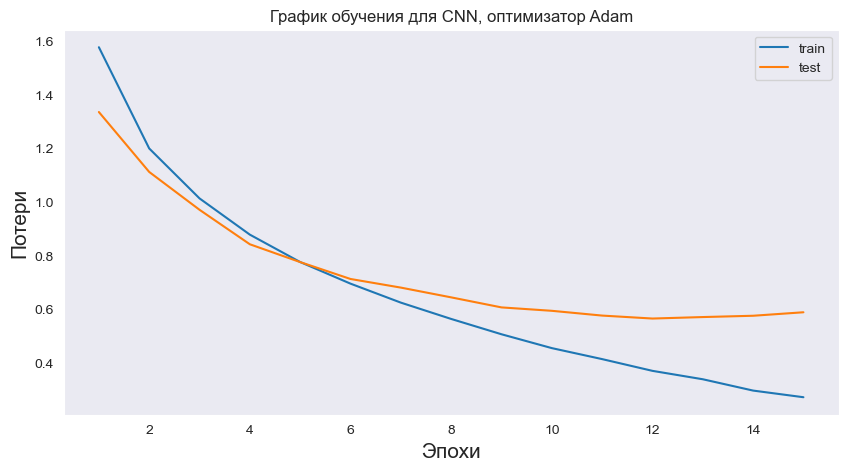

In [173]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.legend()
plt.grid()
plt.title("График обучения для CNN, оптимизатор Adam")
plt.show()

In [177]:
net = model.to('cpu')
y_pred = []
y_true = []
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        X, y = data
        output = net(X)
        y_true += y.tolist()
        y_pred += torch.argmax(output, dim=1).tolist()
        for idx, i in enumerate(output):
             if torch.argmax(i) == y[idx]:
                 correct += 1
             total += 1
print(f'Accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)}%')
print(f'Precision score: {round(precision_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'Recall score: {round(recall_score(y_true, y_pred, average="macro")*100, 2)}%')
print(f'f1 score: {round(f1_score(y_true, y_pred, average="macro")*100, 2)}%')

Accuracy: 82.86%
Precision score: 82.82%
Recall score: 82.86%
f1 score: 82.79%


In [178]:
import torchvision.models as models

In [179]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [180]:
model_vgg= models.vgg19(pretrained=True).to(device)

C:\Users\777\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\777\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\777/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [187]:
model_alex= models.alexnet(pretrained=True).to(device)

C:\Users\777\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\777\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [183]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [182]:
model_alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [188]:
num_epochs = 10
batch_size = 64
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using cuda device


In [189]:
loss_history = {"train": [], "test": []}
start_time = time.time()
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_dataloader, model_alex, loss_function, optimizer)
    test_loss = test_loop(test_dataloader, model_alex, loss_function)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Эпохи", fontsize=15)
plt.ylabel("Потери", fontsize=15)
plt.legend()
plt.grid()
plt.title("График обучения для CNN, оптимизатор Adam")
plt.show()